In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from itertools import chain
from collections import defaultdict

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

%matplotlib inline

C:\Users\Sali1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Blackjack

## Task 1

Checking the simple strategy: if hand > boundary: stop else hit.


In [2]:
def run_game(strategy, env = gym.make('Blackjack-v0', natural = True), verbose = True, *args, **kwargs):
    states = []
    rewards = []
    actions = []
    env.reset()
    while True:
        states.append(env._get_obs())
        action = strategy(env, *args, **kwargs)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            if verbose:
                if reward > 0:
                    print('WIN')
                elif reward < 0:
                    print('LOSE')
                else:
                    print('DRAW')
            break
    env.close()
    return states, rewards, actions

In [3]:
def simple_strategy(env, boundary = 19):
    state = env._get_obs()
    if state[0] < boundary:
        return 1 # hit
    else:
        return 0 # stop

In [4]:
def run_many_games(strategy, env = gym.make('Blackjack-v0', natural = True), n_games = 10000, *args, **kwargs):
    game_rewards = []
    for i in range(n_games):
        _, rewards, _ = run_game(strategy, env, *args, **kwargs)
        game_rewards.append(np.sum(rewards))
    return np.mean(game_rewards)

''

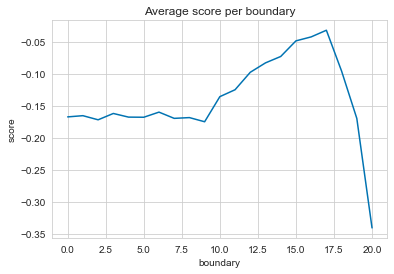

In [5]:
x = np.arange(21)
y = [run_many_games(simple_strategy, verbose = False, boundary = i) for i in x]
plt.plot(x,y)
plt.xlabel('boundary')
plt.ylabel('score')
plt.title('Average score per boundary')
;

By validatiing boundary we will lose to casino anyway :(

### TD learning 

Using TD learning to win it

In [7]:
def e_greedy(env, Q, epsilon = 0.001):
    if np.random.random() > epsilon:
        return np.argmax(Q[env._get_obs()])
    else:
        return np.random.randint(env.action_space.n)

In [8]:
def Q_learning_episode(strategy, env, Q, lr = 0.01, gamma = 0.9, *args, **kwargs):
    env.reset()
    while True:
        #getting current state
        state = env._get_obs()
        
        #action acording to the strategy
        action = strategy(env, Q, *args, **kwargs)
        # step
        next_state, reward, done, _ = env.step(action)

        #refresh Q
        if done:
                Q[state][action] += lr * (reward  - Q[state][action])
                return reward
        else:
                Q[state][action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][action])


In [9]:
def SARSA_learning_episode(strategy, env, Q, lr = 0.01, gamma = 1., *args, **kwargs):
    env.reset()
    while True:
        #getting current state
        state = env._get_obs()
        action = strategy(env, Q, *args, **kwargs)
        # step
        next_state, reward, done, _ = env.step(action)
        #action acording to the strategy
        next_action = strategy(env, Q, *args, **kwargs)
        
        #refresh Q
        if done:
                Q[state][action] += lr * (reward  - Q[state][action])
        else:
                Q[state][action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
        
        #refresh action
        action = next_action
        if done:
            return reward

In [10]:
def run_many_games_Q_learning(strategy, env = gym.make('Blackjack-v0', natural = True), n_games = 1000000, verbose = True, print_every = 10000, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(n_games):
        R = Q_learning_episode(strategy, env, Q, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " avg rewards: {}".format(np.mean(avg_every)))
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

In [11]:
def run_many_games_SARSA_learning(strategy, env = gym.make('Blackjack-v0', natural = True), n_games = 1000000, verbose = True, print_every = 10000, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(n_games):
        R = SARSA_learning_episode(strategy, env, Q, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " avg rewards: {}".format(np.mean(avg_every)))
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

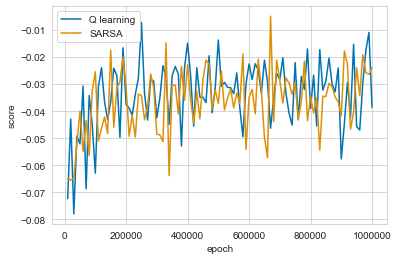

In [12]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, verbose = False)
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, verbose = False)
plt.plot(np.array(list(range(1,101)))*10000, rewards_q_learning, label = 'Q learning')
plt.plot(np.array(list(range(1,101)))*10000, rewards_sarsa, label = 'SARSA')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()

It's better, however not enough to win.\
Let's validate the params of Q-learning and SARSA

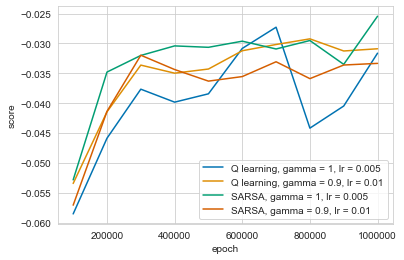

In [14]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, verbose = False, n_games = 1000000, print_every = 100000, lr = 0.005, gamma = 1.)
plt.plot(np.array(list(range(1,11)))*100000, rewards_q_learning, label = 'Q learning, gamma = 1, lr = 0.005')
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, verbose = False, n_games = 1000000, print_every = 100000, lr = 0.01, gamma = 0.9)
plt.plot(np.array(list(range(1,11)))*100000, rewards_q_learning, label = 'Q learning, gamma = 0.9, lr = 0.01')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, verbose = False, n_games = 1000000, print_every = 100000, lr = 0.005, gamma = 1.)
plt.plot(np.array(list(range(1,11)))*100000, rewards_sarsa, label = 'SARSA, gamma = 1, lr = 0.005')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, verbose = False, n_games = 1000000, print_every = 100000, lr = 0.01, gamma = 0.9)
plt.plot(np.array(list(range(1,11)))*100000, rewards_sarsa, label = 'SARSA, gamma = 0.9, lr = 0.01')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()

## Task 2

Changing the BlackJack: adding action double.

In [20]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv_v1(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [21]:
gym.envs.toy_text.blackjack.BlackjackEnv_v1 = BlackjackEnv_v1
if 'Blackjack-v1' in registry.env_specs:
    del registry.env_specs['Blackjack-v1']
    
register(
    id='Blackjack-v1',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnv_v1',
)

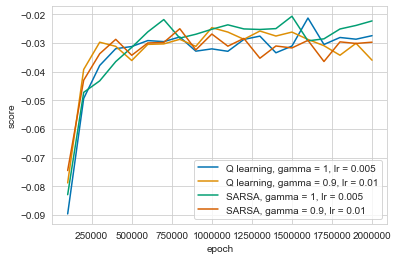

In [17]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v1', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.005, gamma = 1.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_q_learning, label = 'Q learning, gamma = 1, lr = 0.005')
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v1', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.01, gamma = 0.9)
plt.plot(np.array(list(range(1,21)))*100000, rewards_q_learning, label = 'Q learning, gamma = 0.9, lr = 0.01')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, env = gym.make('Blackjack-v1', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.005, gamma = 1.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_sarsa, label = 'SARSA, gamma = 1, lr = 0.005')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, env = gym.make('Blackjack-v1', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.01, gamma = 0.9)
plt.plot(np.array(list(range(1,21)))*100000, rewards_sarsa, label = 'SARSA, gamma = 0.9, lr = 0.01')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()

Q learning + gready strategy (0.001)

In [29]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v1', natural = True), n_games = 1500000, print_every = 100000, lr = 0.01, gamma = 1., epsilon = 0.)

100000/1500000 avg rewards: -0.07769
200000/1500000 avg rewards: -0.046435
300000/1500000 avg rewards: -0.03863
400000/1500000 avg rewards: -0.036695
500000/1500000 avg rewards: -0.032135
600000/1500000 avg rewards: -0.02925
700000/1500000 avg rewards: -0.029375
800000/1500000 avg rewards: -0.028605
900000/1500000 avg rewards: -0.02861
1000000/1500000 avg rewards: -0.035
1100000/1500000 avg rewards: -0.02565
1200000/1500000 avg rewards: -0.030525
1300000/1500000 avg rewards: -0.024675
1400000/1500000 avg rewards: -0.029735
1500000/1500000 avg rewards: -0.0301


## Task 3

Changing the BlackJack: adding action double and now we remeber cards (system +/-)


In [30]:
class BlackjackEnv_v2(gym.Env):
    def __init__(self, natural=False):      
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-20.0, +20.0, shape=(1,1), dtype=np.float32)))
        self.seed()
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.card_counter = 0.0
        self.card_points = {
            1: -1,
            2: 1,
            3: 1,
            4: 1,
            5: 1,
            6: 1,
            7: 0.,
            8: 0.,
            9: 0.,
            10: -1,
        }

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def draw_card(self, np_random):
        card = self.deck.pop(np_random.randint(0, len(self.deck)))
        self.card_counter += self.card_points[card]
        return int(card)


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]


    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21


    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)


    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21


    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)


    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -2.
            else:
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = self.cmp(self.score(self.player), self.score(self.dealer)) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player), self.card_counter)

    def reset(self):
        if len(self.deck) < 15:
            # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.card_counter = 0.0
        
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

gym.envs.toy_text.blackjack.BlackjackEnv_v2 = BlackjackEnv_v2
    
if 'Blackjack-v2' in registry.env_specs:
    del registry.env_specs['Blackjack-v2']
    
register(
    id='Blackjack-v2',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnv_v2',
)

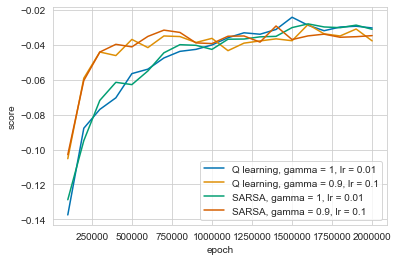

In [31]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v2', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.01, gamma = 1., epsilon = 0.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_q_learning, label = 'Q learning, gamma = 1, lr = 0.01')
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v2', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.1, gamma = 0.9, epsilon = 0.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_q_learning, label = 'Q learning, gamma = 0.9, lr = 0.1')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, env = gym.make('Blackjack-v2', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.01, gamma = 1., epsilon = 0.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_sarsa, label = 'SARSA, gamma = 1, lr = 0.01')
_, rewards_sarsa = run_many_games_SARSA_learning(e_greedy, env = gym.make('Blackjack-v2', natural = True), verbose = False, n_games = 2000000, print_every = 100000, lr = 0.1, gamma = 0.9, epsilon = 0.)
plt.plot(np.array(list(range(1,21)))*100000, rewards_sarsa, label = 'SARSA, gamma = 0.9, lr = 0.1')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()

In [34]:
_, rewards_q_learning = run_many_games_Q_learning(e_greedy, env = gym.make('Blackjack-v2', natural = True), n_games = 2500000, print_every = 100000, lr = 0.01, gamma = 1., epsilon = 0.001)

100000/2500000 avg rewards: -0.131115
200000/2500000 avg rewards: -0.1014
300000/2500000 avg rewards: -0.07652
400000/2500000 avg rewards: -0.068865
500000/2500000 avg rewards: -0.06013
600000/2500000 avg rewards: -0.05214
700000/2500000 avg rewards: -0.047555
800000/2500000 avg rewards: -0.044295
900000/2500000 avg rewards: -0.039425
1000000/2500000 avg rewards: -0.03062
1100000/2500000 avg rewards: -0.033685
1200000/2500000 avg rewards: -0.038135
1300000/2500000 avg rewards: -0.033595
1400000/2500000 avg rewards: -0.02975
1500000/2500000 avg rewards: -0.03737
1600000/2500000 avg rewards: -0.036845
1700000/2500000 avg rewards: -0.02661
1800000/2500000 avg rewards: -0.02576
1900000/2500000 avg rewards: -0.02303
2000000/2500000 avg rewards: -0.026025
2100000/2500000 avg rewards: -0.023045
2200000/2500000 avg rewards: -0.02786
2300000/2500000 avg rewards: -0.02626
2400000/2500000 avg rewards: -0.025495
2500000/2500000 avg rewards: -0.02778
